# Draw segments on the picture

In [17]:
import (
    "log"
    "github.com/mattn/go-tflite"
)

In [18]:
model := tflite.NewModelFromFile("deeplabv3_257_mv_gpu.tflite")
if model == nil {
    log.Fatal("cannot load model")
}

In [19]:
interpreter := tflite.NewInterpreter(model, nil)
if interpreter == nil {
    log.Fatal("cannot create interpreter")
}

In [20]:
interpreter.AllocateTensors()

OK

In [21]:
input := interpreter.GetInputTensor(0)
wanted_height := input.Dim(1)
wanted_width := input.Dim(2)
wanted_type := input.Type()

In [27]:
import (
    "os"
    "image"
    _ "image/jpeg"
    _ "image/png"
    "github.com/nfnt/resize"
)

In [28]:
f, err := os.Open("example.jpg")
if err != nil {
    log.Fatal(err)
}

img, _, err := image.Decode(f)
if err != nil {
    log.Fatal(err)
}

In [29]:
resized := resize.Resize(uint(wanted_width), uint(wanted_height), img, resize.NearestNeighbor)

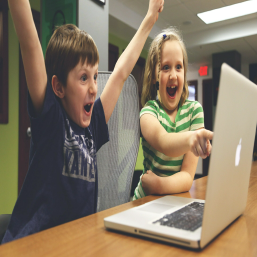

In [30]:
resized

In [32]:
bounds := resized.Bounds()
dx, dy := bounds.Dx(), bounds.Dy()
ff := make([]float32, wanted_width*wanted_height*3)
for y := 0; y < dy; y++ {
    for x := 0; x < dx; x++ {
        col := resized.At(x, y)
        r, g, b, _ := col.RGBA()
        ff[(y*wanted_width+x)*3+0] = ((float32(r) / 255) - 127.0) / 127.0
        ff[(y*wanted_width+x)*3+1] = ((float32(g) / 255) - 127.0) / 127.0
        ff[(y*wanted_width+x)*3+2] = ((float32(b) / 255) - 127.0) / 127.0
    }
}
copy(input.Float32s(), ff)

198147

In [35]:
interpreter.Invoke()

OK

In [37]:
import "image/color"

In [38]:
canvas := image.NewRGBA(resized.Bounds())

output := interpreter.GetOutputTensor(0)
ff := output.Float32s()

for y := 0; y < dy; y++ {
    for x := 0; x < dx; x++ {
        ci := 0
        cv := float32(-32767)
        off := (y*dx + x) * 21
        for i := 0; i < 21; i++ {
            v := ff[off+i]
            if cv < v {
                cv = v
                ci = i
            }
        }
        c := colors[ci]
        canvas.Set(x, y, color.RGBA{R: c[0], G: c[1], B: c[2], A: 100})
    }
}

ERROR: repl.go:18:14: undefined identifier: colors